In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import transforms as T
from PIL import Image

In [2]:
labels_annotations = pd.read_csv('C:\\DATA\\Skin cancer-dataset\\GroundTruth.csv')
labels_annotations.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
labels_annotations['labels'] = ''
class_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

In [4]:
labels_annotations.loc[(labels_annotations['MEL'] != 0.0), 'labels'] = 0
labels_annotations.loc[(labels_annotations['NV'] != 0.0), 'labels'] = 1
labels_annotations.loc[(labels_annotations['BCC'] != 0.0), 'labels'] = 2
labels_annotations.loc[(labels_annotations['AKIEC'] != 0.0), 'labels'] = 3
labels_annotations.loc[(labels_annotations['BKL'] != 0.0), 'labels'] = 4
labels_annotations.loc[(labels_annotations['DF'] != 0.0), 'labels'] = 5
labels_annotations.loc[(labels_annotations['VASC'] != 0.0), 'labels'] = 6

In [5]:
labels = labels_annotations[['image', 'labels']]
labels.head()

,image,labels
0,ISIC_0024306,1
1,ISIC_0024307,1
2,ISIC_0024308,1
3,ISIC_0024309,1
4,ISIC_0024310,0


In [6]:
labels_list = list(labels.iloc[:,1])

In [7]:
labels_list = torch.as_tensor(labels_list, dtype = torch.long)

In [8]:
labels_list

tensor([1, 1, 1,  ..., 4, 1, 1])

In [9]:
class SkinCancerDataset(torch.utils.data.Dataset):
    def __init__(self, targets, img_dir, mask_dir, transforms_img, transforms_mask):
        self.targets = targets
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(os.path.join(self.img_dir))
        self.masks = os.listdir(os.path.join(self.mask_dir))
        self.transforms_img = transforms_img
        self.transforms_mask = transforms_mask

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        img = Image.open(img_path)
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        mask = Image.open(mask_path)
        label = self.targets[idx]
        img = self.transforms_img(img)
        mask = self.transforms_mask(mask)
        return img, mask, label

In [10]:
transformations_img = T.Compose([T.Resize((224, 224)), T.ToTensor(), 
                             T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
transformations_mask = T.Compose([T.Resize((224, 224)), T.ToTensor()])

In [11]:
data = SkinCancerDataset(labels_list, r'C:\DATA\Skin cancer-dataset\images', r'C:\DATA\Skin cancer-dataset\masks', 
                        transformations_img, transformations_mask)

In [12]:
len(data)

10015

In [13]:
val_size = 0.3
val_inds = np.random.choice(len(data), size = int(val_size * len(data)), replace = False)
train_data_split = torch.utils.data.Subset(data, [i for i in range(len(data)) if i not in val_inds])
val_data_split = torch.utils.data.Subset(data, val_inds)
print(len(train_data_split), len(val_data_split))

7011 3004


In [14]:
train_dataloader = torch.utils.data.DataLoader(train_data_split, batch_size = 4, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(val_data_split, batch_size = 4, shuffle = False)

In [15]:
data[0]

(tensor([[[ 1.7352,  1.7694,  1.8037,  ...,  1.7352,  1.7523,  1.7694],
          [ 1.7865,  1.8208,  1.8208,  ...,  1.7180,  1.7352,  1.7523],
          [ 1.8208,  1.7865,  1.7865,  ...,  1.7694,  1.7523,  1.7352],
          ...,
          [ 1.4612,  1.4612,  1.4269,  ...,  1.5125,  1.5468,  1.5125],
          [ 1.4612,  1.4783,  1.4783,  ...,  1.4954,  1.5297,  1.4954],
          [ 1.4440,  1.4440,  1.4612,  ...,  1.4612,  1.4612,  1.4783]],
 
         [[ 0.2227,  0.2577,  0.2577,  ...,  0.2752,  0.2927,  0.3277],
          [ 0.2402,  0.2577,  0.2927,  ...,  0.2927,  0.3277,  0.3277],
          [ 0.2577,  0.2577,  0.2577,  ...,  0.3452,  0.3452,  0.3277],
          ...,
          [ 0.0651,  0.0301, -0.0049,  ...,  0.4503,  0.4503,  0.4153],
          [ 0.0476,  0.0476,  0.0301,  ...,  0.4678,  0.4678,  0.4328],
          [ 0.0476,  0.0476,  0.0301,  ...,  0.4153,  0.4328,  0.4678]],
 
         [[ 0.4439,  0.4962,  0.5659,  ...,  0.4788,  0.5136,  0.5659],
          [ 0.4788,  0.5485,

In [16]:
for imgs, msks, labs in train_dataloader:
    print(imgs.shape, imgs.dtype)
    print(msks.shape, msks.dtype)
    print(labs.shape, labs.dtype)
    break

torch.Size([4, 3, 224, 224]) torch.float32
torch.Size([4, 1, 224, 224]) torch.float32
torch.Size([4]) torch.int64


In [17]:
imgs, msks, labs = next(iter(train_dataloader))

In [18]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [19]:
def show_img(img_tensor, label):
    img = img_tensor.permute(1, 2, 0).numpy()
    img = std * img + mean
    plt.imshow(img.clip(0, 1))
    plt.title(class_names[label])
    plt.show()
    plt.pause(0.001)
def show_msk(msk_tensor, label):
    msk = msk_tensor.permute(1, 2, 0).numpy()
    plt.imshow(msk.clip(0, 1))
    plt.title(class_names[label])
    plt.show()
    plt.pause(0.001)

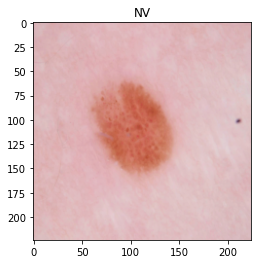

In [20]:
show_img(imgs[0], labs[0])

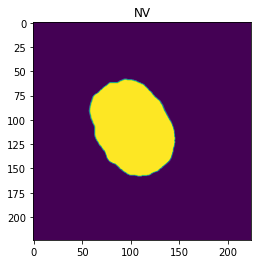

In [21]:
show_msk(msks[0], labs[0])

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
from catalyst.contrib.models.cv.segmentation.unet import Unet
from catalyst.contrib.nn.criterion.dice import DiceLoss
from catalyst.metrics._segmentation import DiceMetric

In [24]:
model = Unet()

In [25]:
model = model.to(device)

In [26]:
loss_func = DiceLoss()
metric = DiceMetric()
optimizer = torch.optim.Adam(model.parameters(), amsgrad = True, lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [29]:
model.eval()
for imgs, msks, _ in train_dataloader:
    imgs = imgs.to(device)
    msks = msks.to(device)
    predictions = model(imgs)
    loss = loss_func(predictions, msks)
    print(predictions.shape)
    print(loss.item())
    break

torch.Size([4, 1, 224, 224])
0.9603007435798645


In [30]:
def train_model(model, train_loader, val_loader, loss_func, metric, optimizer, scheduler, n_epochs):
    
    train_loss = []
    val_loss = []
    acc = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_acc = []
        
        model.train()
        
        for imgs, msks, _ in train_loader:
            optimizer.zero_grad()
            imgs = imgs.to(device)
            msks = msks.to(device)
            predictions = model(imgs)
            loss = loss_func(predictions, msks)
            loss.backward()
            optimizer.step()
            ep_train_loss.append(loss.item())
            
        model.eval()
        
        with torch.no_grad():
            for imgs, msks, _ in val_loader:
                imgs = imgs.to(device)
                msks = msks.to(device)
                predictions = model(imgs)
                loss = loss_func(predictions, msks)
                ep_val_loss.append(loss.item())
                dice = metric.update_key_value(predictions, msks)
                ep_acc.append(dice['dice'].item())
                
        print(f'Epoch {epoch + 1} of {n_epochs}')
        
        scheduler.step()
        
        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        acc.append(np.mean(ep_acc))
        
        print(f"\t train_loss: {train_loss[-1]:.6f}")
        print(f"\t val_loss: {val_loss[-1]:.6f}")
        print(f"\t acc: {acc[-1]:.3f}")
        
    return train_loss, val_loss, acc

In [31]:
train_loss, val_loss, acc = train_model(model, train_dataloader, val_dataloader, loss_func, metric, optimizer, scheduler, 1)

Epoch 1 of 1
	 train_loss: 0.433276
	 val_loss: 1.043513
	 acc: -0.044
